In [1]:
!pip install kaggle
!pip install kagglehub

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install Pillow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Setup

In [2]:
# Copy from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\CindyHong\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
np.random.seed(2024)

# EDA (Exploratory Data Analysis)

In [5]:
# Setting dataset path
path = path+'\\PokemonData\\'
path

'C:\\Users\\CindyHong\\.cache\\kagglehub\\datasets\\lantian773030\\pokemonclassification\\versions\\1\\PokemonData\\'

In [6]:
class_list = pd.read_csv('class_sheet.csv')

In [7]:
class_list.columns,class_list.shape

(Index(['Pokemon', 'Winged', 'Not_Winged', 'Bad_Data'], dtype='object'),
 (150, 4))

### Observation: There are 150 pokemon characters in our dataset

.svg
.svg


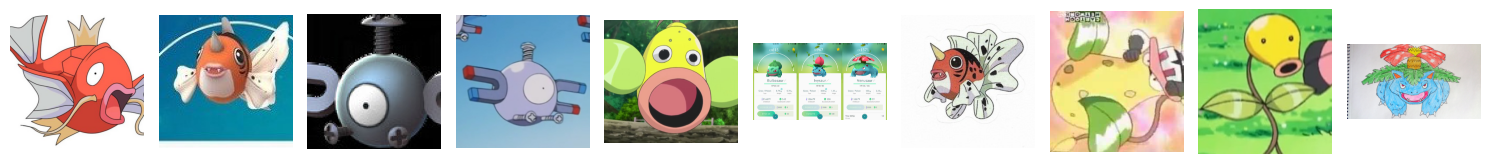

In [8]:
# Plotting 10 images of "bad data"
# Bad data refers to pokemon characters who are wingless species 
# but have features that is similar to wings
bad_class_list = class_list[class_list['Bad_Data'] == 1]['Pokemon']
bad_image_paths = []
valid_extensios = ['.jpg', '.jpeg', '.png']

for folder in bad_class_list:
    bad_image_names = os.listdir(path + folder)
    for image in bad_image_names:
        file_extension = os.path.splitext(image)[1]
        if file_extension not in valid_extensios:
            print(file_extension)
            continue
        bad_image_path = path + folder + '\\' + image
        bad_image_paths.append(bad_image_path)
bad_random_list = np.random.choice(bad_image_paths, 10, replace=False)

plt.figure(figsize=(15, 10))
for i,image_path in enumerate(bad_random_list):  
    with Image.open(image_path) as img:
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: There are pokemon characters who are wingless species but have features that is similar to wings in our dataset. We can drop these "bad data" to make our work easier.

In [9]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [10]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [11]:
# Making a data frame that has the image paths and their classifcation
images = []
wrong_extensions = []
valid_extensios = ['.jpg', '.jpeg', '.png']

for folder in winged:
    image_names = os.listdir(path + folder)
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensios:
            wrong_extensions.append(file_extension)
            continue
        image_path = path + folder + '\\' + image
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Winged'})
            
for folder in not_winged:
    image_names = os.listdir(path + folder)
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensios:
            wrong_extensions.append(file_extension)
            continue
        image_path = path + folder + '\\' + image
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Not Winged'})
            
df = pd.DataFrame(images)
set(wrong_extensions)

{'.asp',
 ".jpg')",
 '.jpg~c200',
 '.sb-334870d9-FK2TVI',
 '.sb-334870d9-nlD60H',
 '.svg'}

### Observation: There are some image data in formats that can't be read by PIL(Python Imaging Library), so that we need to ignore them.

In [12]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

Dataframe shape: (6017, 2)
Source
Not Winged    5180
Winged         837
Name: count, dtype: int64


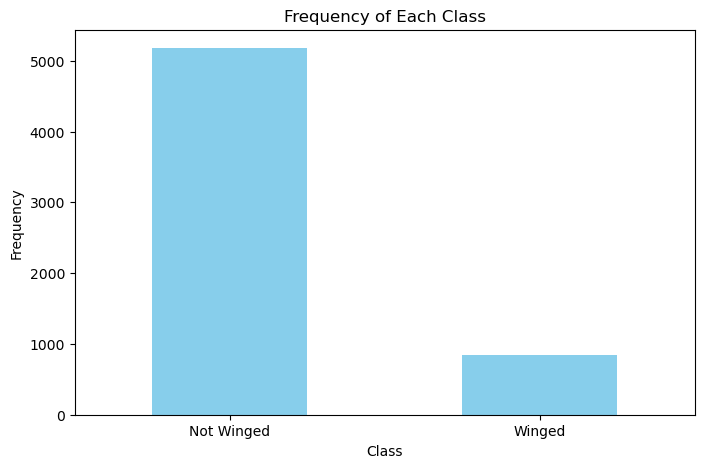

In [13]:
# Plotting frequencies of classes to check for data imbalance
source_counts = df['Source'].value_counts()
plt.figure(figsize=(8, 5))
source_counts.plot(kind='bar', color='skyblue')
plt.title("Frequency of Each Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)  
print("Dataframe shape:",df.shape)
print(source_counts)
plt.show()

### Observation: Not Winged class has way more examples than Winged, We'd either have to sample equal number of images from both sets or use a weight balanced optimizer

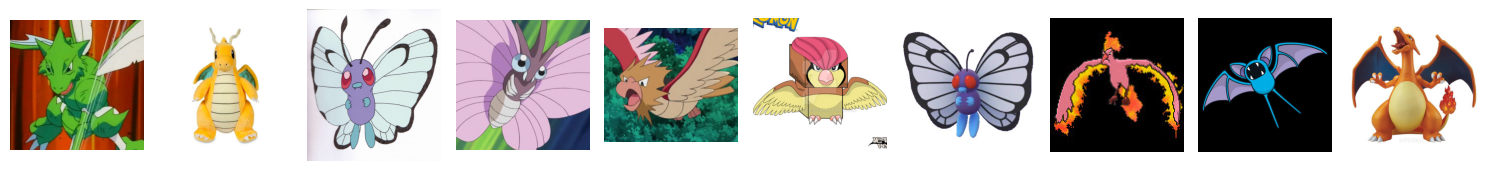

In [14]:
# plotting example classes of the winged image
Winged_random_list = np.random.choice(df[df['Source']=='Winged']['Image'], 10, replace=False)
plt.figure(figsize=(15, 10))
for i,img in enumerate(Winged_random_list):
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

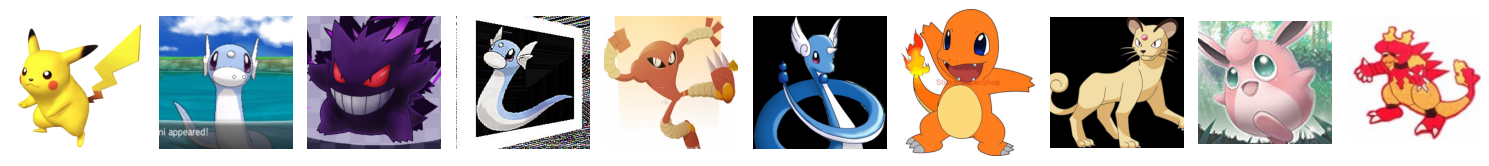

In [15]:
# plotting example classes of the not winged image
NWinged_random_list = np.random.choice(df[df['Source']=='Not Winged']['Image'], 10, replace=False)
plt.figure(figsize=(15, 10))
for i,img in enumerate(NWinged_random_list):
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

In [16]:
# Observing data shape
for i in np.random.choice(df['Image'].shape[0],size=10, replace=False):
    print(df['Image'][i].shape)

(250, 250, 3)
(267, 267, 3)
(185, 186, 3)
(265, 261, 3)
(674, 674, 3)
(1026, 1026, 3)
(375, 379, 3)
(727, 729, 3)
(881, 939, 3)
(600, 590, 3)


### Observation: Our image data consists of image tensors with a shape format of (height, width, RGB)

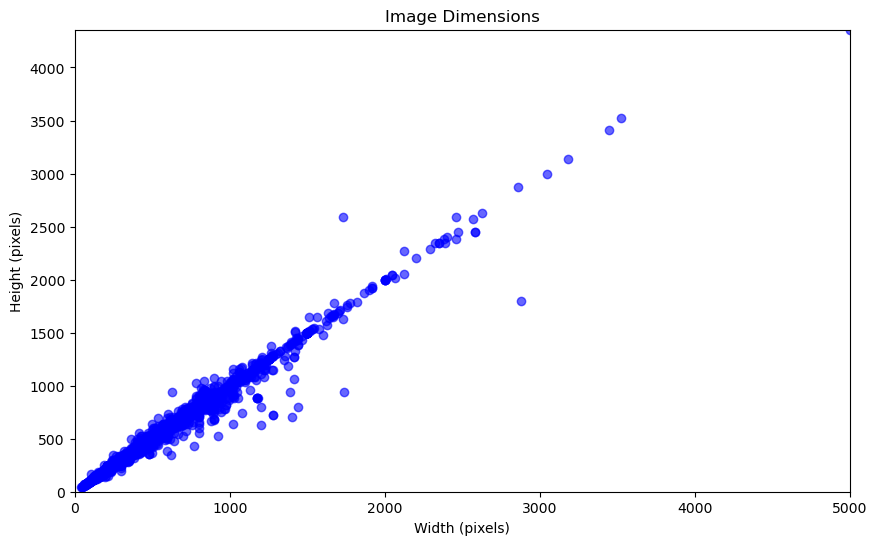

In [17]:
# Plotting the image pixel values
widths = []
heights = []

for img in df['Image']:
            widths.append(img.shape[1])
            heights.append(img.shape[0])

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', alpha=0.6)
plt.title("Image Dimensions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.xlim(0, max(widths))  
plt.ylim(0, max(heights))  
plt.show()

### Observation: The dimensions of images are varying, we'd have to resize all of them to a common size

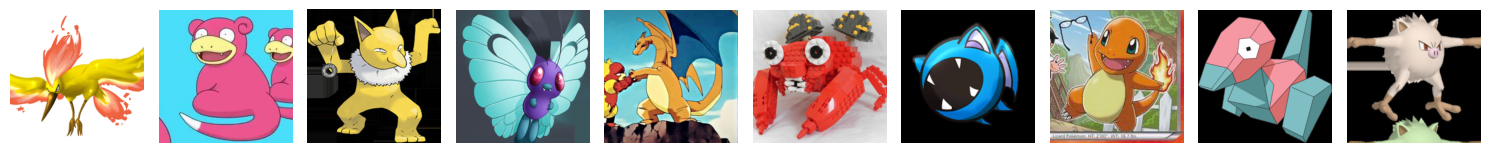

In [18]:
# Plotting 10 images after they've been resized
new_size = (224, 224)
resized_images = []

random_list = np.random.choice(df['Image'], 10, replace=False)

for img in random_list:
    resized_img = Image.fromarray(img).resize(new_size)
    resized_images.append(resized_img)

plt.figure(figsize=(15, 10))
for i, resized_img in enumerate(resized_images):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(resized_img)
    plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: After resizing, the image retains its prominent features, so we can expect a good fit. 

After ploting multiple random images of the Pokemon characters, we learned that the images of characters various in the style of visual representation.
- 3D rendering
- Plush photos
- Pokemon card
- Cartoon/anime
- Drawing
- Pokemon Go
- Realistic background
- Empty/single color background

### Therefore, we need to normalize the image data to eliminate the effect of different backgrounds on feature extraction.

There are also variations in the depictions of the pokemon:
- orientation
- shape
- for some pokemon, there may be special forms that make it hard to distinguish
- there is possibility for occlusion
- inclusion of English text

However, generally, the pokemon is centered in the image and is the main object.

# Data Preprocessing

In [19]:
# Arrays to store flattened images and their classifications
X = []
y = []

In [20]:
# Going through all images and resizing them, converting them to grayscale and normalizing pixel values
for index, row in df.iterrows():

    # Resize images to 224 x 224
    img = Image.fromarray(row['Image']).resize(new_size)

    # Convert images to grayscale
    img = img.convert('L') 
    
    # Normalize pixel values
    img = np.array(img)
    mean = img.mean(axis=(0, 1), keepdims=True)
    std = img.std(axis=(0, 1), keepdims=True)
    img = (img - mean) / std
    
    X.append(img)
    y.append(1 if row['Source'] == 'Winged' else 0)
X = np.array(X)
y = np.array(y)

In [21]:
X.shape

(6017, 224, 224)

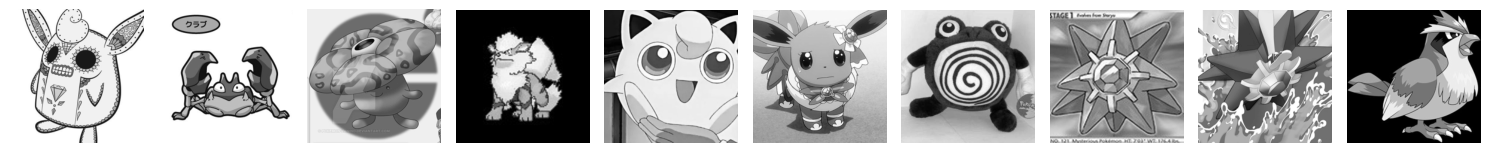

In [22]:
# Plotting 10 images after preprocessing
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img, cmap='gray') 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [23]:
# Balancing the data set by random sampling
id_not_winged = np.where(y == 0)[0]
id_winged = np.where(y == 1)[0]
sample_not_winged = np.random.choice(id_not_winged, size=600, replace=False)
sample_winged = np.random.choice(id_winged, size=600, replace=False)
sample = np.concatenate((sample_not_winged, sample_winged), axis=0)
X = X[sample]
y = y[sample]
# Creating Train/Validate/Test splits (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
X_train.shape, X_val.shape, X_test.shape

((960, 224, 224), (120, 224, 224), (120, 224, 224))